In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data 

In [3]:
# generate data for grid network (features and costs)
grid = (5,5) # grid graph
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
x, c = pyepo.data.shortestpath.genData(n+1000, p, grid, deg=deg)

## Optimization Model 

In [4]:
# model for shortest path
sp_model = pyepo.model.grb.shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-05-05


In [5]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [7]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [8]:
# get training data set
sp_dataset_train = pyepo.data.dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1070.43it/s]


In [9]:
# get test data set
sp_dataset_test = pyepo.data.dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1107.17it/s]


In [10]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [11]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [12]:
x.shape

torch.Size([32, 5])

In [13]:
c.shape

torch.Size([32, 40])

In [14]:
w.shape

torch.Size([32, 40])

In [15]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Learn 

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
# prediction model
reg = LinearRegression()

## Two-Stage

In [18]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [19]:
# training
twostage_model.fit(sp_dataset_train.feats, sp_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [20]:
# prediction
c_test_pred = twostage_model.predict(sp_dataset_test.feats)

In [21]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = sp_dataset_test.costs[i]
    z_true_i = sp_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(sp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(sp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized Regret: {:.2f}%".format(truespo / abs(sp_dataset_test.objs.sum()) * 100))
print("Normalized Unambiguous Regret: {:.2f}%".format(unambspo / abs(sp_dataset_test.objs.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 252.15it/s]


Normalized Regret: 1.61%
Normalized Unambiguous Regret: 1.61%


In [22]:
# compare solutions
for i, data in enumerate(sp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: " + ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.28, 0.16, 0.55, -0.67, 0.99, -0.21, -0.41, 0.30, -0.19, 0.41, -0.21, 0.04, -0.57, 0.30, -0.33, 0.30, -0.84, 0.20, 0.05, -0.21, 0.04, 0.20, 0.57, -0.09, 0.79, -0.41, -0.33, -0.33, 0.46, 0.55, 0.33, -0.57, 0.33, 0.16, 0.55, 0.55, -0.41, 0.55, -0.05, 0.20
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.10

## Linear Regression from PyTorch

In [23]:
from torch import nn

In [24]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+

In [25]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [26]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [27]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [28]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch   5, Loss:   0.4286, Regret:  2.7066%, Unambiguous Regret:  2.7067%
Epoch  10, Loss:   0.3381, Regret:  2.0131%, Unambiguous Regret:  2.0140%
Epoch  15, Loss:   0.5032, Regret:  1.1006%, Unambiguous Regret:  1.1006%
Epoch  20, Loss:   0.9621, Regret:  1.7000%, Unambiguous Regret:  1.7000%
Epoch  25, Loss:   0.2259, Regret:  1.4014%, Unambiguous Regret:  1.4014%
Epoch  30, Loss:   0.3652, Regret:  1.7893%, Unambiguous Regret:  1.7893%
Epoch  35, Loss:  -0.0000, Regret:  0.8063%, Unambiguous Regret:  0.8063%
Epoch  40, Loss:   0.6532, Regret:  0.8888%, Unambiguous Regret:  0.8888%
Epoch  45, Loss:   0.1927, Regret:  1.1359%, Unambiguous Regret:  1.1359%
Epoch  50, Loss:   0.1346, Regret:  1.0847%, Unambiguous Regret:  1.0847%
Epoch  55, Loss:   0.0759, Regret:  1.4050%, Unambiguous Regret:  1.4050%
Epoch  60, Loss:   0.8865, Regret:  0.8965%, Unambiguous Regret:  0.8965%
Epoch  65, Loss:   0.8212, Regret:  1.0826%, Unambiguous Regret:  1.0826%
Epoch  70, Loss:   0.0645, Regret:  0.

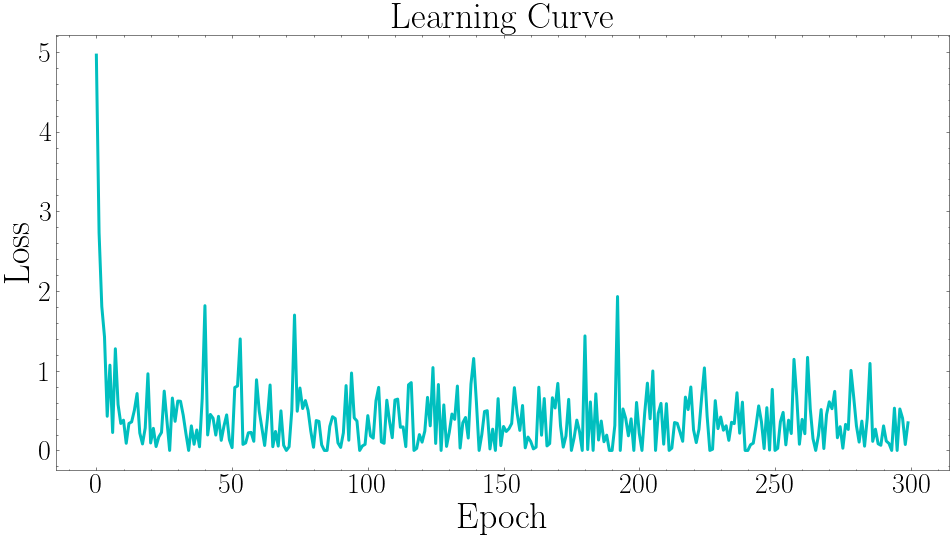

In [29]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

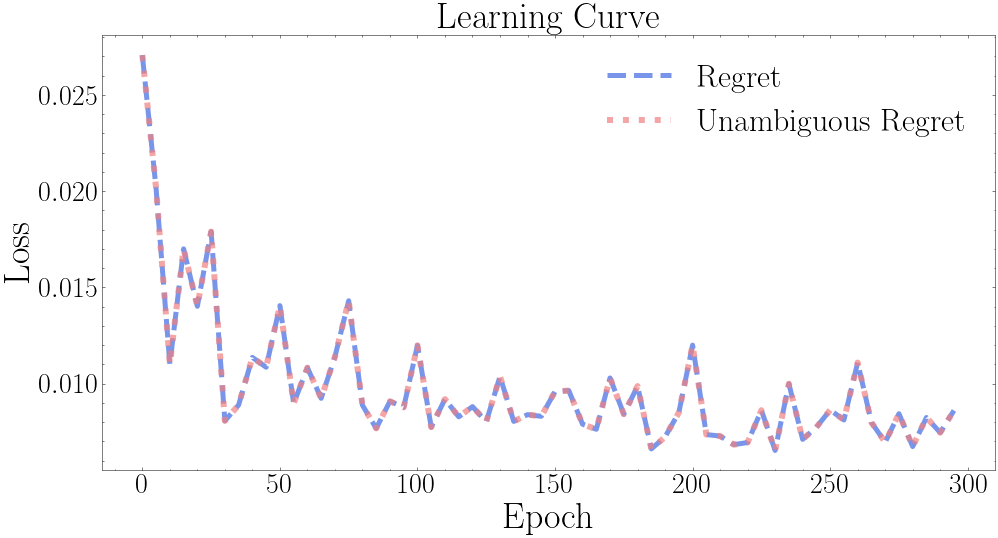

In [30]:
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()
#fig.savefig("./images/regret_curve01.pdf", dpi=300)

In [31]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 0.86%
Normalized Unambiguous Regret: 0.86%


In [32]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -2.86, -0.35, 0.38, 0.32, 2.90, -2.00, 0.02, -0.46, -0.56, 2.23, -0.77, -2.61, -0.22, 1.34, -0.83, 2.52, -2.98, -1.17, 1.05, -0.90, -1.54, -0.87, -0.37, 1.21, 0.38, -1.58, -0.62, 0.41, 0.01, 3.39, 0.70, -0.86, 1.10, -1.73, 0.62, -0.28, 0.05, 0.36, 0.39, -0.73
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.34

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17,

##  SPO+ with Regularization

In [33]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [34]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [35]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(sp_model, processes=4)

Num of cores: 4


In [36]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).mean(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch   5, Loss:   0.3829, Regret:  1.9071%, Unambiguous Regret:  1.9071%
Epoch  10, Loss:   0.9389, Regret:  2.5376%, Unambiguous Regret:  2.5376%
Epoch  15, Loss:   0.1791, Regret:  1.3550%, Unambiguous Regret:  1.3550%
Epoch  20, Loss:   0.2009, Regret:  1.1757%, Unambiguous Regret:  1.1757%
Epoch  25, Loss:   0.5255, Regret:  1.8200%, Unambiguous Regret:  1.8200%
Epoch  30, Loss:   0.0010, Regret:  0.9365%, Unambiguous Regret:  0.9365%
Epoch  35, Loss:   0.3421, Regret:  1.0619%, Unambiguous Regret:  1.0619%
Epoch  40, Loss:   0.2449, Regret:  1.0096%, Unambiguous Regret:  1.0096%
Epoch  45, Loss:   0.1603, Regret:  1.1632%, Unambiguous Regret:  1.1632%
Epoch  50, Loss:   0.2102, Regret:  1.1354%, Unambiguous Regret:  1.1354%
Epoch  55, Loss:   0.5484, Regret:  1.4178%, Unambiguous Regret:  1.4178%
Epoch  60, Loss:   0.0608, Regret:  2.2567%, Unambiguous Regret:  2.2567%
Epoch  65, Loss:   0.3404, Regret:  1.4132%, Unambiguous Regret:  1.4132%
Epoch  70, Loss:   0.2936, Regret:  1.

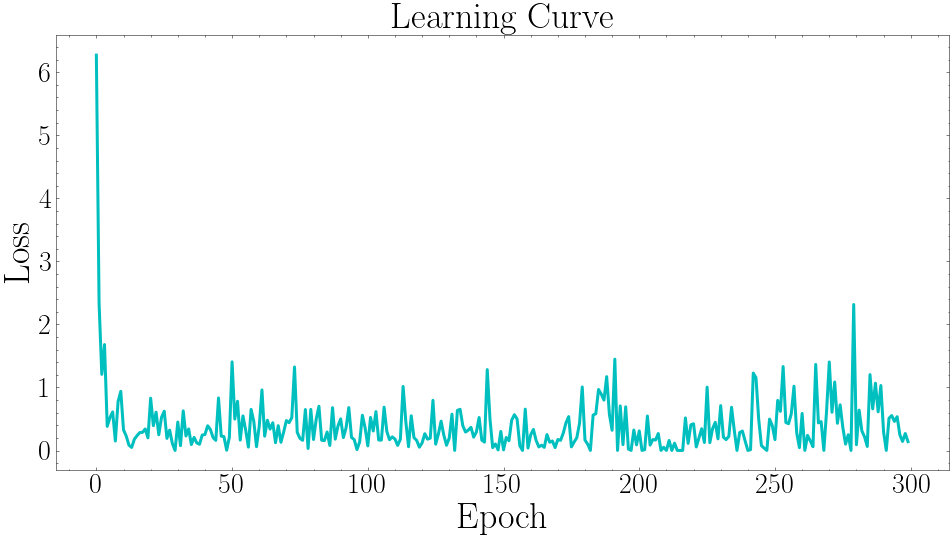

In [37]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

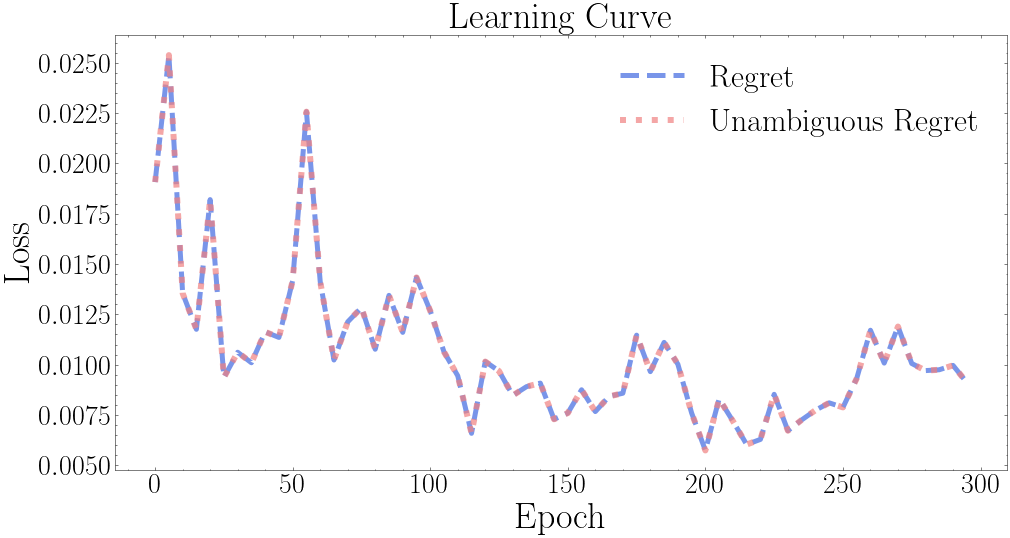

In [38]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [39]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 0.91%
Normalized Unambiguous Regret: 0.91%


In [40]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -2.68, 0.33, 0.33, -0.20, 1.76, -1.32, -0.37, 0.22, 0.02, 0.33, -0.82, -2.66, -1.53, 0.51, -0.48, 2.00, -2.29, -0.04, 1.22, -1.21, -1.07, -0.73, 0.82, -0.26, 1.04, -2.32, -0.98, -0.15, -0.37, 3.65, 0.38, 0.18, 0.67, -1.99, 0.51, 0.20, -0.80, -1.12, -0.25, -0.41
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.1

## Black-Box

In [41]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [42]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [43]:
# set loss
criterion = nn.L1Loss()
bb = pyepo.func.blackboxOpt(sp_model, lambd=20, processes=4)

Num of cores: 4


In [44]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch   5, Loss:   0.3440, Regret: 18.0933%, Unambiguous Regret: 18.0933%
Epoch  10, Loss:   0.3335, Regret:  9.7771%, Unambiguous Regret:  9.7771%
Epoch  15, Loss:   0.3534, Regret:  9.5210%, Unambiguous Regret:  9.5211%
Epoch  20, Loss:   0.3797, Regret: 11.3708%, Unambiguous Regret: 11.3710%
Epoch  25, Loss:   0.3383, Regret:  6.2519%, Unambiguous Regret:  6.2519%
Epoch  30, Loss:   0.1417, Regret:  7.1859%, Unambiguous Regret:  7.1859%
Epoch  35, Loss:   0.0977, Regret:  8.1323%, Unambiguous Regret:  8.1324%
Epoch  40, Loss:   0.6682, Regret:  7.2142%, Unambiguous Regret:  7.2606%
Epoch  45, Loss:   0.3829, Regret:  8.2390%, Unambiguous Regret:  8.2392%
Epoch  50, Loss:   0.0686, Regret:  7.2206%, Unambiguous Regret:  7.2209%
Epoch  55, Loss:   0.0943, Regret:  8.6171%, Unambiguous Regret:  8.6174%
Epoch  60, Loss:   2.1337, Regret: 12.7999%, Unambiguous Regret: 12.8002%
Epoch  65, Loss:   0.5523, Regret:  5.4998%, Unambiguous Regret:  5.5001%
Epoch  70, Loss:   0.1293, Regret:  6.

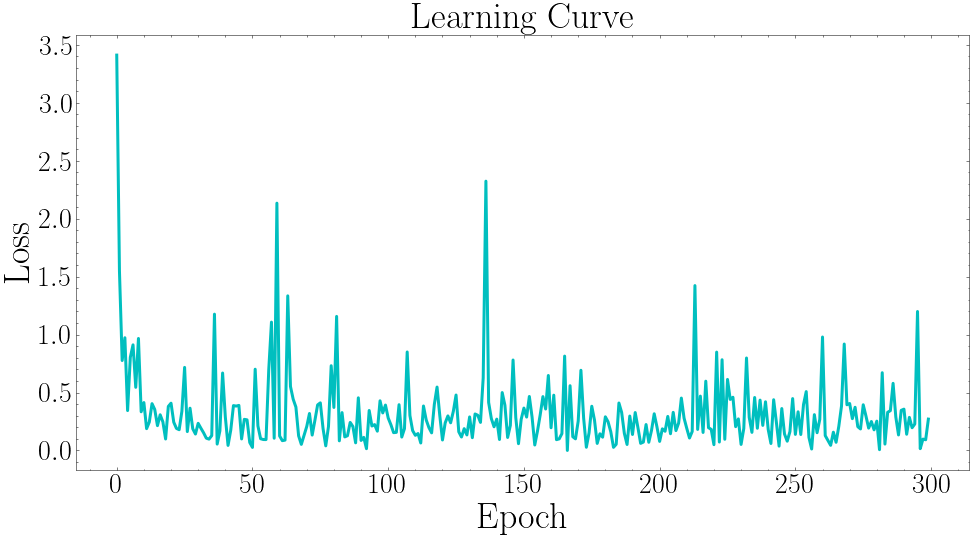

In [45]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

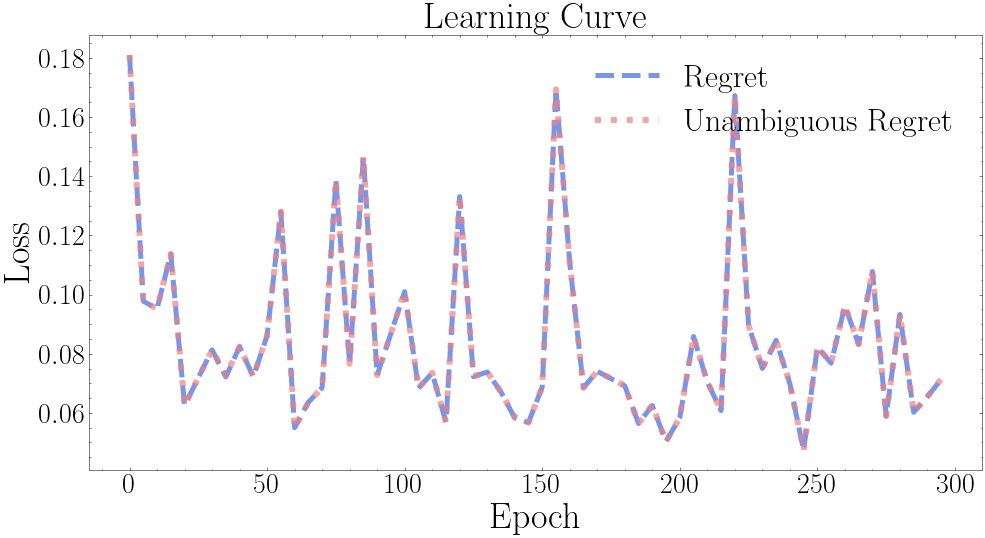

In [46]:
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()
#fig.savefig("./images/regret_curve02.pdf", dpi=300)

In [47]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 7.13%
Normalized Unambiguous Regret: 7.15%


In [48]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: 0.36, -0.22, -0.01, -0.24, 0.47, -0.47, -0.06, 0.81, -0.20, -0.57, 0.19, 0.03, -0.43, -1.11, 0.07, 0.25, -0.06, 0.25, 0.61, 0.36, -0.25, -0.11, 0.26, 0.04, 0.10, 0.95, -0.08, 0.38, 0.42, 0.61, -1.15, 1.52, 0.47, 0.19, -0.47, 0.42, -0.08, 0.19, -0.06, -0.27
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 1.47

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85, 0.17, 0.

## Black-Box with Regularization

In [49]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [50]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-3)

In [51]:
# set loss
bb = pyepo.func.blackboxOpt(sp_model, lambd=20, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [52]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-5
        l1_reg = torch.abs(cp - c).mean(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 5 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%, Unambiguous Regret: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch   5, Loss:   0.6936, Regret: 26.4169%, Unambiguous Regret: 26.4169%
Epoch  10, Loss:   0.4144, Regret: 12.8122%, Unambiguous Regret: 12.8122%
Epoch  15, Loss:   0.2070, Regret:  8.9002%, Unambiguous Regret:  8.9002%
Epoch  20, Loss:   0.2021, Regret:  5.7676%, Unambiguous Regret:  5.7676%
Epoch  25, Loss:   0.3048, Regret:  5.9441%, Unambiguous Regret:  5.9442%
Epoch  30, Loss:   0.1366, Regret:  6.7425%, Unambiguous Regret:  6.7426%
Epoch  35, Loss:   0.0071, Regret:  7.9036%, Unambiguous Regret:  7.9038%
Epoch  40, Loss:   0.0643, Regret:  9.8301%, Unambiguous Regret:  9.8302%
Epoch  45, Loss:   0.1414, Regret: 10.2740%, Unambiguous Regret: 10.2741%
Epoch  50, Loss:   0.1362, Regret:  8.2354%, Unambiguous Regret:  8.2355%
Epoch  55, Loss:   0.1151, Regret: 10.4041%, Unambiguous Regret: 10.4049%
Epoch  60, Loss:   0.1097, Regret:  5.2795%, Unambiguous Regret:  5.2881%
Epoch  65, Loss:   0.0880, Regret:  6.8198%, Unambiguous Regret:  6.8201%
Epoch  70, Loss:   0.1777, Regret:  4.

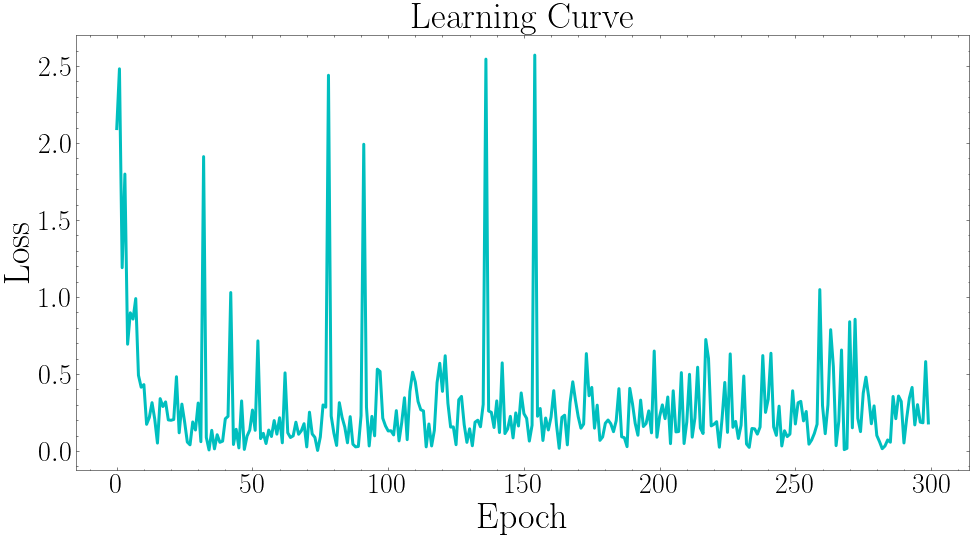

In [53]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

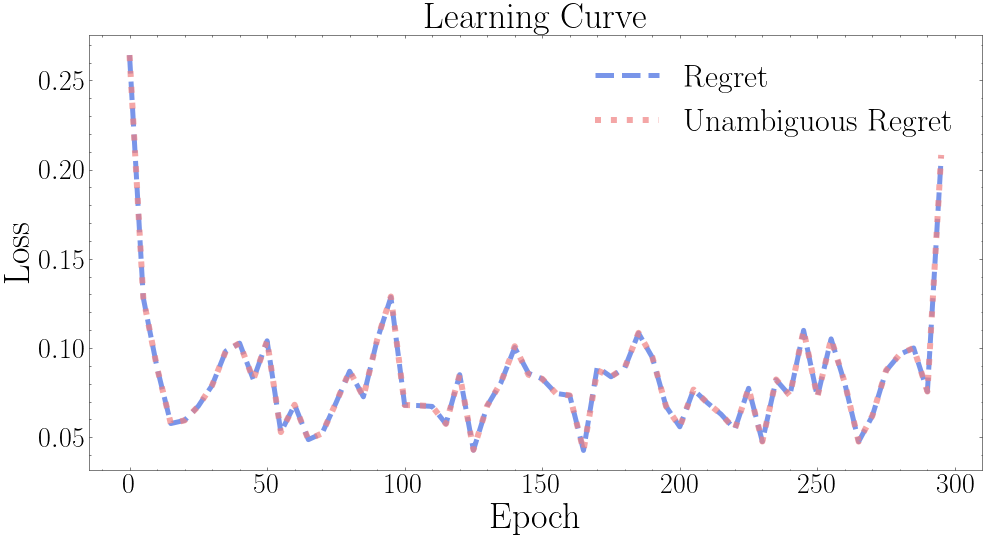

In [54]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 5), loss_log_truespo, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.plot(range(0, num_epochs, 5), loss_log_unambspo, color="lightcoral", ls=":", alpha=0.7, lw=6, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [55]:
# evaluate
spoloss = pyepo.metric.regret(reg, sp_model, sp_loader_test)
print("Normalized Regret: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, sp_model, sp_loader_test)
print("Normalized Unambiguous Regret: {:.2f}%".format(spoloss * 100))

Normalized Regret: 20.67%
Normalized Unambiguous Regret: 20.82%


In [56]:
# compare solutions
reg.eval()
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 0.24, 0.18, 0.55, 0.03, 0.81, 0.09, 0.06, 0.21, 0.10, 0.34, 0.09, 0.17, 0.04, 0.21, 0.07, 0.21, 0.02, 0.25, 0.15, 0.09, 0.17, 0.25, 0.40, 0.14, 0.70, 0.06, 0.07, 0.07, 0.37, 0.41, 0.30, 0.04, 0.30, 0.18, 0.55, 0.41, 0.06, 0.41, 0.12, 0.25
    Pred cost: -0.49, 0.14, 0.08, -0.50, -0.59, -0.50, 0.07, 0.85, -0.43, -0.38, 0.69, -0.40, -0.49, -0.04, 0.30, -0.74, 0.34, -0.01, -0.04, -0.38, 0.70, -0.86, 0.53, 0.84, 0.60, -0.46, -0.86, 0.27, -0.62, -0.35, -1.26, 0.81, -0.07, -0.77, -0.83, -0.19, -0.62, -1.31, -0.41, -0.62
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 1.34
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 1.40

Sample 1:
    True cost: 0.01, 0.66, 0.55, 0.13, 0.09, 0.02, 0.08, 0.37, 0.07, 0.33, 0.02, 0.04, 0.06, 0.37, 0.05, 0.37, 0.41, 0.85, 0.91, 0.02, 0.04, 0.85,